#Sentiment & purchasing intent analysis for adidas in social media

This notebook covers a Natural Language Processing with [TensorFlow](https://tfhub.dev/) to analyze the sentiment and intent of purchase over the tweets scraped with the previous [tool](https://github.com/fco-parga/EIT---Adidas/blob/main/PythonCode/twitterScraper_v02.ipynb).


##Libraries needed

In [ ]:
# Import necessary libraries.
import re, string, unicodedata
import nltk                                   # Natural language processing tool-kit

!pip install contractions
import contractions


from bs4 import BeautifulSoup                 # Beautiful soup is a parsing library that can use different parsers.
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import unicodedata


     |████████████████████████████████| 321 kB 7.5 MB/s 
     |████████████████████████████████| 284 kB 50.8 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85452 sha256=c3ae39aab77efd88e08a392c865eadf7913c7e97d7fddaa51648d392508f3aa9
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


##Complementary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib # To save models to disk
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Loading tweets scraped

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/EnhanceIT/Training/Exercises/Week6/W6_Project/"

In [ ]:
tweets = pd.read_excel(path+'twitter/All_twitts_v02.xlsx')

In [ ]:
tweets.head()

,created_at,id,text,Lab,sentiment,intent
0,2021-08-30T00:34:05.000Z,1.430000e+18,One of my favorite goals against FC Dallas 18/...,POS,0,0
1,2021-08-30T00:31:26.000Z,1.430000e+18,Check out my amazing son @anthemslegolife subs...,POS,0,0
2,2021-08-30T00:22:35.000Z,1.430000e+18,Happy Birthday MJ! ðŸŽ‰ðŸŽ¶ What was MJ best m...,POS,0,0
3,2021-08-30T00:15:49.000Z,1.430000e+18,proving how tough and persistent iam to the la...,POS,1,1
4,2021-08-30T06:44:46.000Z,1.430000e+18,"@MR_JiBoLA Yes and Iâ€™m saying, as an artist ...",POS,1,0


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   created_at  967 non-null    object 
 1   id          929 non-null    float64
 2   text        967 non-null    object 
 3   Lab         501 non-null    object 
 4   sentiment   967 non-null    int64  
 5   intent      967 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 45.5+ KB


In [ ]:
tw_data = tweets.copy()

## Functions to clean the imput

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")    # Removing HTML tags
    return soup.get_text()


def denoise_text(text):
    text = strip_html(text)
    # Any other step can also be added here according to need e.g we can add code to remove string inside the curly braces.
    return text


def replace_contractions(text):
    #"""Replace contractions in string of text"""
    return contractions.fix(text)


def remove_links(text):
  return re.sub(r'https:?:\/\/.*[\r\n]*','',text) #remove links


def remove_punct(text):
  return "".join([char for char in text if char not in string.punctuation])


def remove_accented_chars(text):  #defined function, text is the input variable
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  #result is assigned into text variable
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9]+','',text)   #Additional cleaning
  text = re.sub(r'#','',text)
  text = re.sub(r'RT[\s]+','',text)
  text = re.sub(r'https?:\/\/\S+','',text)

  return text


def clean_text(text):   
  text = strip_html(text)
  text = denoise_text(text)
  text = replace_contractions(text)
  text = remove_links(text)
  text = remove_punct(text)
  text = remove_accented_chars(text)
  text = remove_special_characters(text)
  text = cleanTxt(text)
  text = text.lower()
  return text


Executing the cleaning function in all the data frame

In [ ]:
for i in range(len(tw_data)):
  tw_data['text'][i] = clean_text(tw_data['text'][i])

tw_data['text'] = tw_data['text'].str.lower()

In [ ]:
tw_data[90:100]

,created_at,id,text,Lab,sentiment,intent
90,2021-08-31T16:28:39.000Z,1.430000e+18,i had purchased adidas jh696 on 3aug21 from ku...,POS,-1,0
91,2021-08-31T16:15:44.000Z,1.430000e+18,adidas nearly everyone in the us was affected...,POS,-1,0
92,2021-08-31T17:32:12.000Z,1.430000e+18,having worked withfor eric liedtke at adidas g...,POS,0,0
93,2021-08-31T17:31:24.000Z,1.430000e+18,adidas hooking up uwfootball with a 30th anniv...,POS,1,2
94,2021-08-31T17:08:59.000Z,1.430000e+18,jerseys look great \n\ndonatmt know why adidas...,POS,1,2
95,2021-08-31T18:51:37.000Z,1.430000e+18,when the shoe box is better looking then the a...,POS,-1,0
96,2021-08-31T18:14:50.000Z,1.430000e+18,if these truly are available on 96 then i may ...,POS,1,2
97,2021-08-31T19:40:06.000Z,1.430000e+18,does anyone else think these ronaldo pics look...,POS,1,2
98,2021-08-31T19:36:31.000Z,1.430000e+18,chartsjisoo adidasoriginals adidas originalskr...,POS,1,0
99,2021-08-31T19:16:30.000Z,1.430000e+18,justinling not sure if youatmve driven a benz ...,POS,0,0


In [ ]:
tw_data.shape

(967, 6)

In [ ]:
tw_data.nunique()

created_at    866
id              1
text          906
Lab             4
sentiment       3
intent          3
dtype: int64

Dropping repeated tweets

In [ ]:
tw_unq = tw_data.drop_duplicates(subset='text')

In [ ]:
tw_unq.nunique()

created_at    863
id              1
text          906
Lab             4
sentiment       3
intent          3
dtype: int64

##Lematization

In [ ]:
import en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [ ]:
#tw_data['Lemmas'] = lemmatization(tw_data,'text','Lemmas')

In [ ]:
tw_data['Lemmas'] = tw_data['text'] 
for i in range(len(tw_data)):
  tw_data["Lemmas"][i] = lemmatize_text(tw_data['Lemmas'][i])

In [ ]:
tw_data[90:100]

,created_at,id,text,Lab,sentiment,intent,Lemmas
90,2021-08-31T16:28:39.000Z,1.430000e+18,i had purchased adidas jh696 on 3aug21 from ku...,POS,-1,0,i have purchase adida jh696 on 3aug21 from kur...
91,2021-08-31T16:15:44.000Z,1.430000e+18,adidas nearly everyone in the us was affected...,POS,-1,0,adida nearly everyone in the us be affect bu...
92,2021-08-31T17:32:12.000Z,1.430000e+18,having worked withfor eric liedtke at adidas g...,POS,0,0,have work withfor eric liedtke at adidas globa...
93,2021-08-31T17:31:24.000Z,1.430000e+18,adidas hooking up uwfootball with a 30th anniv...,POS,1,2,adida hook up uwfootball with a 30th anniversa...
94,2021-08-31T17:08:59.000Z,1.430000e+18,jerseys look great \n\ndonatmt know why adidas...,POS,1,2,jersey look great \n\n donatmt know why adidas...
95,2021-08-31T18:51:37.000Z,1.430000e+18,when the shoe box is better looking then the a...,POS,-1,0,when the shoe box be better look then the actu...
96,2021-08-31T18:14:50.000Z,1.430000e+18,if these truly are available on 96 then i may ...,POS,1,2,if these truly be available on 96 then i may h...
97,2021-08-31T19:40:06.000Z,1.430000e+18,does anyone else think these ronaldo pics look...,POS,1,2,do anyone else think these ronaldo pic look li...
98,2021-08-31T19:36:31.000Z,1.430000e+18,chartsjisoo adidasoriginals adidas originalskr...,POS,1,0,chartsjisoo adidasoriginal adida originalskr h...
99,2021-08-31T19:16:30.000Z,1.430000e+18,justinling not sure if youatmve driven a benz ...,POS,0,0,justinle not sure if youatmve drive a benz aud...


In [ ]:
tw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,929.0,1.430000e+18,36371.580933,1.430000e+18,1.430000e+18,1.430000e+18,1.430000e+18,1.430000e+18
sentiment,967.0,2.347466e-01,0.841295,-1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
intent,967.0,4.281282e-01,0.738441,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00


#Word cloud

In [ ]:
from wordcloud import WordCloud

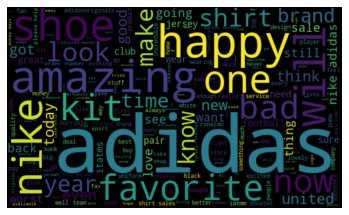

In [ ]:
allwords = ''.join([twts for twts in tw_data['text']])
wordcloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size= 119).generate(allwords)

plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis('off')
plt.show()

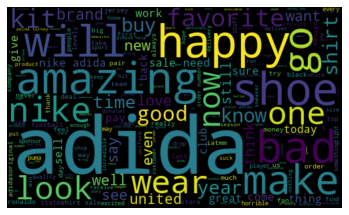

In [ ]:
allwords = ''.join([twts for twts in tw_data['Lemmas']])
wordcloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size= 119).generate(allwords)

plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis('off')
plt.show()

#Basic Sentiment analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License](https://choosealicense.com/)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
tw_data.shape

(967, 7)

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment=[]
for i in range(len(tw_data)):
     ss = sid.polarity_scores(tw_data['text'][i])
     sentiment.append(ss)

In [ ]:
np.array(sentiment).shape

(967,)

In [ ]:
compound=[sentiment[i]['compound'] for i in range(len(sentiment))]
tw_data['compound']=compound

In [ ]:
tw_data[90:100]

,created_at,id,text,Lab,sentiment,intent,Lemmas,compound
90,2021-08-31T16:28:39.000Z,1.430000e+18,i had purchased adidas jh696 on 3aug21 from ku...,POS,-1,0,i have purchase adida jh696 on 3aug21 from kur...,0.2105
91,2021-08-31T16:15:44.000Z,1.430000e+18,adidas nearly everyone in the us was affected...,POS,-1,0,adida nearly everyone in the us be affect bu...,-0.0772
92,2021-08-31T17:32:12.000Z,1.430000e+18,having worked withfor eric liedtke at adidas g...,POS,0,0,have work withfor eric liedtke at adidas globa...,0.8013
93,2021-08-31T17:31:24.000Z,1.430000e+18,adidas hooking up uwfootball with a 30th anniv...,POS,1,2,adida hook up uwfootball with a 30th anniversa...,0.4588
94,2021-08-31T17:08:59.000Z,1.430000e+18,jerseys look great \n\ndonatmt know why adidas...,POS,1,2,jersey look great \n\n donatmt know why adidas...,0.3716
95,2021-08-31T18:51:37.000Z,1.430000e+18,when the shoe box is better looking then the a...,POS,-1,0,when the shoe box be better look then the actu...,0.7003
96,2021-08-31T18:14:50.000Z,1.430000e+18,if these truly are available on 96 then i may ...,POS,1,2,if these truly be available on 96 then i may h...,0.8720
97,2021-08-31T19:40:06.000Z,1.430000e+18,does anyone else think these ronaldo pics look...,POS,1,2,do anyone else think these ronaldo pic look li...,0.8591
98,2021-08-31T19:36:31.000Z,1.430000e+18,chartsjisoo adidasoriginals adidas originalskr...,POS,1,0,chartsjisoo adidasoriginal adida originalskr h...,0.9153
99,2021-08-31T19:16:30.000Z,1.430000e+18,justinling not sure if youatmve driven a benz ...,POS,0,0,justinle not sure if youatmve drive a benz aud...,0.9290


In [ ]:
def getanalysis(score):
  if score < -0.1:
    return 'negative'
  elif score >= -0.1 and score <= 0.1:
    return 'neutral'
  else:
    return 'positive'


In [ ]:
tw_data['analysis'] = tw_data['compound'].apply(getanalysis)
tw_data[90:100]

,created_at,id,text,Lab,sentiment,intent,Lemmas,compound,analysis
90,2021-08-31T16:28:39.000Z,1.430000e+18,i had purchased adidas jh696 on 3aug21 from ku...,POS,-1,0,i have purchase adida jh696 on 3aug21 from kur...,0.2105,positive
91,2021-08-31T16:15:44.000Z,1.430000e+18,adidas nearly everyone in the us was affected...,POS,-1,0,adida nearly everyone in the us be affect bu...,-0.0772,neutral
92,2021-08-31T17:32:12.000Z,1.430000e+18,having worked withfor eric liedtke at adidas g...,POS,0,0,have work withfor eric liedtke at adidas globa...,0.8013,positive
93,2021-08-31T17:31:24.000Z,1.430000e+18,adidas hooking up uwfootball with a 30th anniv...,POS,1,2,adida hook up uwfootball with a 30th anniversa...,0.4588,positive
94,2021-08-31T17:08:59.000Z,1.430000e+18,jerseys look great \n\ndonatmt know why adidas...,POS,1,2,jersey look great \n\n donatmt know why adidas...,0.3716,positive
95,2021-08-31T18:51:37.000Z,1.430000e+18,when the shoe box is better looking then the a...,POS,-1,0,when the shoe box be better look then the actu...,0.7003,positive
96,2021-08-31T18:14:50.000Z,1.430000e+18,if these truly are available on 96 then i may ...,POS,1,2,if these truly be available on 96 then i may h...,0.8720,positive
97,2021-08-31T19:40:06.000Z,1.430000e+18,does anyone else think these ronaldo pics look...,POS,1,2,do anyone else think these ronaldo pic look li...,0.8591,positive
98,2021-08-31T19:36:31.000Z,1.430000e+18,chartsjisoo adidasoriginals adidas originalskr...,POS,1,0,chartsjisoo adidasoriginal adida originalskr h...,0.9153,positive
99,2021-08-31T19:16:30.000Z,1.430000e+18,justinling not sure if youatmve driven a benz ...,POS,0,0,justinle not sure if youatmve drive a benz aud...,0.9290,positive


#Intent Analysis with [TensorFlow](https://www.tensorflow.org/)

TensorFlow is a free and open-source software library for machine learning and artificial intelligence. It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks. Tensorflow is a symbolic math library based on dataflow and differentiable programming

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib # To save models to disk
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import io
import sys

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split

Utilizing only labeled tweets

In [ ]:
tweets_label = tw_data.dropna()
tweets_label = tweets_label.drop_duplicates(subset='text')
tweets_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 500
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   created_at  500 non-null    object 
 1   id          500 non-null    float64
 2   text        500 non-null    object 
 3   Lab         500 non-null    object 
 4   sentiment   500 non-null    int64  
 5   intent      500 non-null    int64  
 6   Lemmas      500 non-null    object 
 7   compound    500 non-null    float64
 8   analysis    500 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 39.1+ KB


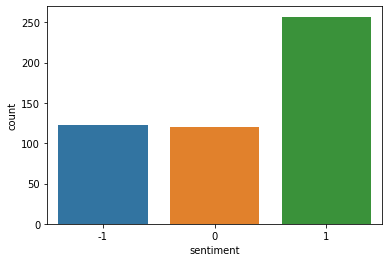

In [ ]:
sns.countplot(tweets_label['sentiment'])

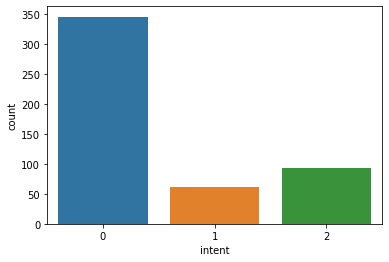

In [ ]:
sns.countplot(tweets_label['intent'])

##Splitting data

In [ ]:
#Droping targets
X = tweets_label.drop(columns=['sentiment','intent'])

y = tweets_label['intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Onehot colum encoding
y_train_dum=pd.get_dummies(y_train,drop_first=False)
y_test_dum=pd.get_dummies(y_test,drop_first=False)

y_train_dum = np.array(y_train_dum)
y_test_dum = np.array(y_test_dum)


##Balancing data


Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#rus = RandomUnderSampler(random_state = 1,ratio={0.0: 150, 1.0: 39, 2.0: 39})
rus = RandomUnderSampler(random_state = 1,sampling_strategy='majority')
X_train_un, y_train_un = rus.fit_resample(X_train, y_train_dum)

(array([[122.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 278.],
        [354.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  46.],
        [324.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  76.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 Lists of Patches objects>)

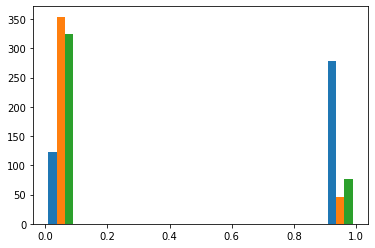

In [ ]:
plt.hist(y_train_dum)

(array([[122.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  46.],
        [122.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  46.],
        [ 92.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  76.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 Lists of Patches objects>)

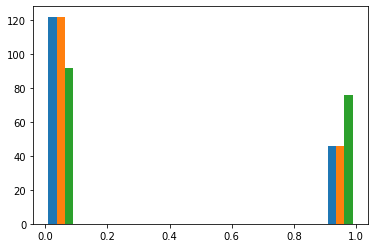

In [ ]:
plt.hist(y_train_un)

In [ ]:
#Run for BALANCED data
#Select text to train with: EditedText = 1, lemmas =2
label = 2
X_train_un = X_train_un[:,label]
X_test = X_test.iloc[:,label]

In [ ]:
X_train_un.shape, y_train_un.shape

((168,), (168, 3))

In [ ]:
X_train_un[96],  y_train_un[96]

('the new adidas don issue 3 has some flaws in its stability and traction but the full integration of the lightstrike cushion tech could make this an exciting shoe to rock on the basketball court\n\nread below for the full performance review y\n\n',
 array([0, 0, 1]))

##Control ponts for intent of purchase

Since the tweet data was limited to only 7 days of scraping, the corpus is bias to this time frame.
To improve the model prediction strength the control points were imputed to the training set.

In [ ]:
X_train_un = pd.DataFrame(X_train_un)
y_train_un = pd.DataFrame(y_train_un)

In [ ]:
#To complement the knowledge for the model, control points.
toaddX = ['i want adidas',
          'i need adidas',
          'will buy adidas',
          'have to have adidas',
          'tomorrow will go to store to buy adidas',
          'if i get a discount i will buy adidas',
          'i am looking for adidas',
          'my next purchase will be adidas',
          'i am waiting for the launch to get my adidas',
          'will be the fist to by adidas',
          'i am looking for adidas',
          'can anyone help to look for adidas',
          'buy adidas',
          'will not buy adidas',
          'I don not want adidas',
          'never buying adidas',
          'perhaps i might buy adidas',
          'i am thinking to buy adidas',
          'probably i will buy adidas']
toaddY = [[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],
          [1, 0, 0],[1, 0, 0],[1, 0, 0],
          [0, 1, 0],[0, 1, 0],[0, 1, 0]]        
for inx,tx in enumerate(toaddX):
  toaddX[inx] = clean_text(str(tx))
  toaddX[inx] = lemmatize_text(tx)
  toaddX[inx] = "".join(tx)

toaddX = pd.DataFrame(toaddX)
toaddY = pd.DataFrame(toaddY)

In [ ]:
toaddX, toaddY

In [ ]:
#X_train_un.append(toaddX,ignore_index=True)
X_train_un = np.array(X_train_un.append(toaddX,ignore_index=True))

#y_train_un.append(toaddY,ignore_index=True)
y_train_un = np.array(y_train_un.append(toaddY,ignore_index=True))

In [ ]:
X_train_un.shape, y_train_un.shape

((187, 1), (187, 3))

#Creating Model

Text embedding based on feed-forward Neural-Net Language Models [1](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) with pre-built OOV. Maps from text to 128-dimensional embedding vectors.

In [ ]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim128/2'
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype = tf.string, trainable=True)

In [ ]:
# Creating Model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(y_train_un.shape[1], activation='softmax')) #for multiclass should be submax

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 99        
Total params: 124,653,123
Trainable params: 124,653,123
Non-trainable params: 0
________________________________________

In [ ]:
X_train_un.shape

(187, 1)

In [ ]:
model.compile(optimizer='Nadam', loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_un, y_train_un,validation_split=0.3, epochs=50, verbose=1,use_multiprocessing=True, workers=2)  # Balenced Data

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 0.7500 - accuracy: 0.2769 - val_loss: 0.7638 - val_accuracy: 0.0526
Epoch 2/50
5/5 [==============================] - 5s 968ms/step - loss: 0.7022 - accuracy: 0.3615 - val_loss: 0.7441 - val_accuracy: 0.0526
Epoch 3/50
5/5 [==============================] - 5s 968ms/step - loss: 0.6684 - accuracy: 0.4000 - val_loss: 0.7229 - val_accuracy: 0.0526
Epoch 4/50
5/5 [==============================] - 5s 982ms/step - loss: 0.6689 - accuracy: 0.4308 - val_loss: 0.7148 - val_accuracy: 0.0526
Epoch 5/50
5/5 [==============================] - 5s 964ms/step - loss: 0.6288 - accuracy: 0.4692 - val_loss: 0.7084 - val_accuracy: 0.0526
Epoch 6/50
5/5 [==============================] - 5s 973ms/step - loss: 0.6349 - accuracy: 0.4077 - val_loss: 0.7026 - val_accuracy: 0.0526
Epoch 7/50
5/5 [==============================] - 5s 953ms/step - loss: 0.6239 - accuracy: 0.4538 - val_loss: 0.6959 - val_accuracy: 0.0526
Epoch 8/50
5/5 [=======

In [ ]:
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [ ]:
print(hist)

        loss  accuracy  val_loss  val_accuracy  epoch
0   0.750000  0.276923  0.763799      0.052632      0
1   0.702177  0.361538  0.744108      0.052632      1
2   0.668368  0.400000  0.722863      0.052632      2
3   0.668905  0.430769  0.714764      0.052632      3
4   0.628785  0.469231  0.708372      0.052632      4
5   0.634914  0.407692  0.702563      0.052632      5
6   0.623923  0.453846  0.695911      0.052632      6
7   0.583271  0.592308  0.693980      0.070175      7
8   0.568675  0.584615  0.668891      0.105263      8
9   0.538355  0.661538  0.656174      0.175439      9
10  0.498843  0.715385  0.653914      0.210526     10
11  0.479418  0.746154  0.652269      0.263158     11
12  0.448847  0.876923  0.647224      0.280702     12
13  0.447622  0.815385  0.636019      0.421053     13
14  0.454370  0.853846  0.625080      0.438596     14
15  0.405522  0.869231  0.602710      0.526316     15
16  0.396781  0.853846  0.608358      0.491228     16
17  0.390291  0.876923  0.59

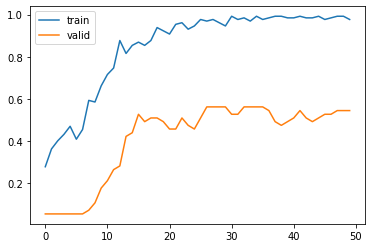

In [ ]:
#Lets plot the metrics MSE per epoch
import matplotlib.pyplot as plt

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)


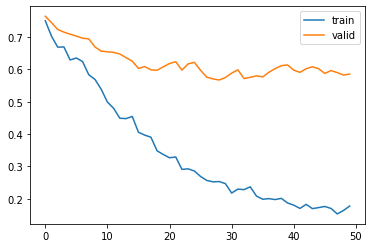

In [ ]:
#Lets plot the metrics MSE per epoch
import matplotlib.pyplot as plt

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)


In [ ]:
model.save(path+'models/intent.h5')

In [ ]:
#Now run it against test set
loss = model.evaluate(X_test, y_test_dum, verbose=True)

4/4 [==============================] - 1s 166ms/step - loss: 0.6079 - accuracy: 0.5000


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape

(100, 3)

In [ ]:
lis = []
for ind, cls in enumerate(y_test_dum):
  #print(ind)
  #print(cls)
  if cls[2] == 1:
    lis.append(ind)


In [ ]:
lis

[2, 8, 11, 27, 33, 39, 41, 55, 56, 64, 69, 72, 79, 86, 87, 88, 99]

In [ ]:
i = 56
j = i+1
X_test[i:j], y_test_dum[i:j], y_pred[i:j]

(148    jjeffrose adidas ebay same shoe haha 300 shipp...
 Name: text, dtype: object,
 array([[0, 0, 1]], dtype=uint8),
 array([[0.05713545, 0.03493903, 0.9079255 ]], dtype=float32))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred_mx = np.argmax(y_pred, axis=-1)
y_test_dum_mx = np.argmax(y_test_dum, axis=-1)

In [ ]:
cm = confusion_matrix(y_test_dum_mx, y_pred_mx)
pd.DataFrame(cm)

,0,1,2
0,37,13,17
1,7,6,3
2,4,6,7


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test_dum_mx, y_pred_mx))

              precision    recall  f1-score   support

           0       0.80      0.42      0.55        67
           1       0.25      0.50      0.33        16
           2       0.21      0.41      0.28        17

    accuracy                           0.43       100
   macro avg       0.42      0.44      0.39       100
weighted avg       0.61      0.43      0.47       100



#Assest input

In [ ]:
def evaluate_tw(text):
  tw_cln = clean_text(str(text))
  tw_lemm = lemmatize_text(tw_cln)
  tw_lemm = "".join(tw_lemm)
  ss_tw = sid.polarity_scores(tw_lemm)
  tw_pred = model.predict([tw_lemm])

  print(tw_lemm)
  print('Sentiment: ')
  print(np.array(ss_tw))
  print('Intent of purchase: ')
  print(np.array(tw_pred))


In [ ]:
#tw_input = ['This is a test to demo the results of the model, loving adidas']
tw_input = ['I will buy some adidas']
evaluate_tw([tw_input])

i will buy some adida
Sentiment: 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Intent of purchase: 
[[0.0784023  0.03494947 0.88664824]]
